# Use [markdown](https://www.markdownguide.org/basic-syntax/) to label each (sub)question neatly.

This notebook serves as your report. All your answers should be presented within it. 

You can submit multiple notebooks (e.g. 1 notebook per part / question).

Before submission, remember to tidy up the notebook and retain only relevant parts.

In [1]:
import time
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import shap
shap.initjs()


import IPython.display as ipd

from scipy.io import wavfile as wav

from sklearn import preprocessing
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix


import tensorflow.keras as keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import *
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau,EarlyStopping,ModelCheckpoint,LearningRateScheduler


c:\Users\JoeTe\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
SEED = 42
import os
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'

import random 
random.seed(SEED)

import numpy as np
np.random.seed(SEED)

import tensorflow as tf
tf.random.set_seed(SEED)

# Read Data

In [3]:
df = pd.read_csv('./full.csv') 
df.head()

,filename,tempo,total_beats,average_beats,chroma_stft_mean,chroma_stft_var,chroma_cq_mean,chroma_cq_var,chroma_cens_mean,chroma_cens_var,...,mfcc15_mean,mfcc15_var,mfcc16_mean,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var
0,app_3001_4001_phnd_neg_0000.wav,184.570312,623,69.222222,0.515281,0.093347,0.443441,0.082742,0.249143,0.021261,...,-10.669799,63.340282,1.811605,58.117188,-3.286546,54.268448,-2.719069,59.548176,-4.559987,70.774803
1,app_3001_4001_phnd_neg_0001.wav,151.999081,521,74.428571,0.487201,0.094461,0.542182,0.073359,0.274423,0.008025,...,-5.666375,90.256195,1.573594,105.070496,-0.742024,82.417496,-1.961745,119.312355,1.513660,101.014572
2,app_3001_4001_phnd_neg_0002.wav,112.347147,1614,146.727273,0.444244,0.099268,0.442014,0.083224,0.264430,0.013410,...,-5.502390,73.079750,0.202623,72.040550,-4.021009,73.844353,-5.916223,103.834824,-2.939086,113.598824
3,app_3001_4001_phnd_neg_0003.wav,107.666016,2060,158.461538,0.454156,0.100834,0.424370,0.084435,0.257672,0.016938,...,-8.812989,93.791893,-0.429413,60.002579,-4.013513,82.544540,-5.858006,84.402092,0.686969,90.126389
4,app_3001_4001_phnd_neg_0004.wav,75.999540,66,33.000000,0.478780,0.100000,0.414859,0.089313,0.252143,0.019757,...,-6.584204,64.973305,0.744403,68.908516,-6.354805,66.414391,-6.555534,47.852840,-4.809713,73.033966


In [4]:
df['label'] = df['filename'].str.split('_').str[-2]

In [5]:
df['label'].value_counts()

pos    92826
neg    89428
Name: label, dtype: int64

Split and scale dataset

In [6]:

columns_to_drop = ['label','filename']

def split_dataset(df, columns_to_drop, test_size, random_state):
  label_encoder = preprocessing.LabelEncoder()

  df['label'] = label_encoder.fit_transform(df['label'])

  df_train, df_test = train_test_split(df, test_size=test_size, random_state=random_state)

  df_train2 = df_train.drop(columns_to_drop,axis=1)
  y_train2 = df_train['label'].to_numpy()

  df_test2 = df_test.drop(columns_to_drop,axis=1)
  y_test2 = df_test['label'].to_numpy() 

  return df_train2, y_train2, df_test2, y_test2

def preprocess_dataset(df_train, df_test):

  standard_scaler = preprocessing.StandardScaler()
  df_train_scaled = standard_scaler.fit_transform(df_train)

  df_test_scaled = standard_scaler.transform(df_test)

  return df_train_scaled, df_test_scaled

X_train, y_train, X_test, y_test = split_dataset(df, columns_to_drop, test_size=0.3, random_state=0) # positive labels being encoded as 1

X_train_scaled, X_test_scaled = preprocess_dataset(X_train, X_test)

In [7]:
features = []
for i in X_train.columns[0:]:
    features.append(i)

## Question 1A

In [8]:
num_neurons = 128
learning_rate = 0.001
batch_size = 256
no_epochs = 100

In [9]:
model = Sequential([Dense(num_neurons, activation='relu'),
                    Dropout(0.2), Dense(num_neurons, activation ='relu'),
                    Dropout(0.2), Dense(num_neurons, activation='relu'),
                    Dropout(0.2), Dense(1, activation='sigmoid')])


In [10]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
model.compile(loss= 'binary_crossentropy', optimizer = "adam", metrics= ['accuracy']) #Default learning rate for adam algo is 0.001

In [11]:
history = {}
history['model'] = model.fit(X_train_scaled, y_train,
                            epochs = no_epochs, verbose = 0,
                            batch_size = batch_size, validation_data = (X_test_scaled, y_test), callbacks = [callback])

### Plotting train and test accuracies and loss against training epochs

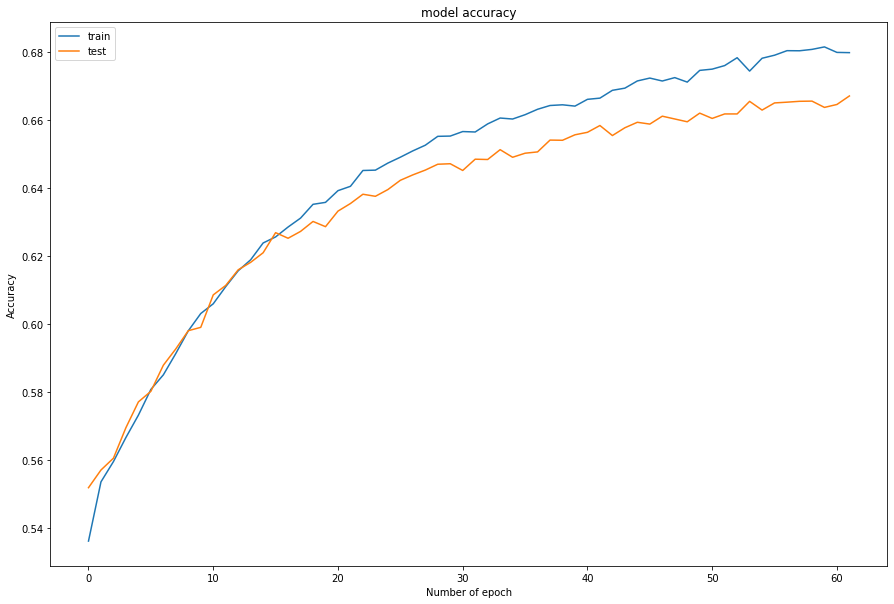

In [12]:
plt_1 = plt.figure(figsize=(15, 10))
plt.plot(history['model'].history['accuracy'])
plt.plot(history['model'].history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Number of epoch')
plt.legend(['train', 'test'], loc='upper left')
#plt.savefig('figures/1a_accuracy.png')
plt.show()

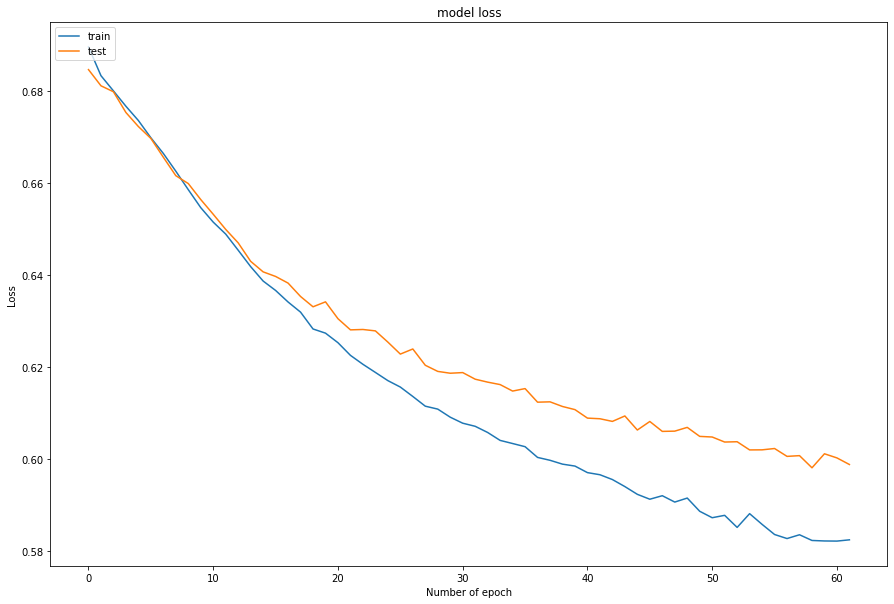

In [13]:
plt_1 = plt.figure(figsize=(15, 10))
plt.plot(history['model'].history['loss'])
plt.plot(history['model'].history['val_loss'])
plt.title('model loss')
plt.ylabel('Loss')
plt.xlabel('Number of epoch')
plt.legend(['train', 'test'], loc='upper left')
#plt.savefig('figures/1a_loss.png')
plt.show()

## Question 1B

#### Comments on the line plots

**Both training and validation accuracies of the model is increasing at a decreasing rate. Initially as the model trains, accuracy of the model rises sharply and its growth would decrease and if there was no early-stopping mechanism, the model might overfit which compromise on the model's accuracy.**

**Both training and validation loss are decreasing. Loss indicates the error or "how bad" the predictions are against the targeted value. We aim to minimize loss as it indicates robustness of the model.**



#### Why early stopping is required?

**Early stopping is required to reduce overfitting without compromising on model accuracy. With the early stopping technique, the model will stop training before it starts to overfit which leads to increase in error and a drop in model's accuracy.**


## Question 2

In [14]:
from sklearn import datasets
from sklearn.model_selection import KFold

**Timing callback for every epoch**

In [15]:
#TimingCallBack class for Q2b

class TimingCallback(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.times = []

    def on_epoch_begin(self, epoch, logs={}):
        self.epoch_time_start = time.time()

    def on_epoch_end(self, epoch, logs={}):
        self.times.append(time.time() - self.epoch_time_start)



In [16]:
no_folds = 5
batch_size_list = [128, 256, 512, 1024]
cv = KFold(n_splits=no_folds, shuffle=True, random_state=0)

In [17]:
Q2_X, Q2_Y = X_train_scaled, y_train

In [18]:
model_acc = {}
model_train_acc = {}
model_loss = {}
Q2_history = {}
time_taken_dict = {}
batch_idx = 0

model_list = ["model_128", "model_256", "model_512", "model_1024"]
model_fold = ["_0", "_1", "_2", "_3" ,"_4"]

for models in model_list:
    fold = 0
    train_acc = []
    val_acc = []
    val_loss = []
    time_taken_list = []
    for train_idx, test_idx in cv.split(Q2_X, Q2_Y):
        cb = TimingCallback()
        Q2_X_train, Q2_y_train  = Q2_X[train_idx], Q2_Y[train_idx]
        Q2_X_test, Q2_y_test = Q2_X[test_idx], Q2_Y[test_idx]
    
        
        Q2_model = Sequential([Dense(num_neurons, activation='relu'),
                        Dropout(0.2), Dense(num_neurons, activation ='relu'),
                        Dropout(0.2), Dense(num_neurons, activation='relu'),
                        Dropout(0.2), Dense(1, activation='sigmoid')])
        
        Q2_model.compile(optimizer='adam', 
                    loss='binary_crossentropy',
                    metrics=['accuracy'])
        
        Q2_history[models + model_fold[fold]] = Q2_model.fit(Q2_X_train, Q2_y_train,
                        batch_size = batch_size_list[batch_idx],
                        epochs=no_epochs,
                        verbose=0,
                        use_multiprocessing=True,
                        validation_data=(Q2_X_test, Q2_y_test), callbacks=[callback, cb])
        
        #Time taken of final epoch for each fold 
        time_taken_list.append(cb.times[-1])
        #print("Time Taken for final epoch " + models + model_fold[fold] + " : {}".format(cb.times[-1]))

        #Validation Accuracy of final epoch of each fold
        val_acc.append(Q2_history[models + model_fold[fold]].history['val_accuracy'][-1])

        #Training Accuracy of final epoch of each fold
        train_acc.append(Q2_history[models + model_fold[fold]].history['accuracy'][-1])
        
        #Val loss of final epoch of each fold
        val_loss.append(Q2_history[models + model_fold[fold]].history['val_loss'][-1])

        #print(models +' fold %d test accuracy %g'%(fold, val_acc[fold]))
        fold += 1
    
    batch_idx +=1
    model_acc[models] = val_acc
    model_train_acc[models] = train_acc
    model_loss[models] = val_loss
    time_taken_dict[models]= time_taken_list
    #print(models + '* mean accuracy = %g *'% np.mean(val_acc))
    


## Question 2A) 

**Mean Cross-validation accuracies against different batch_sizes**

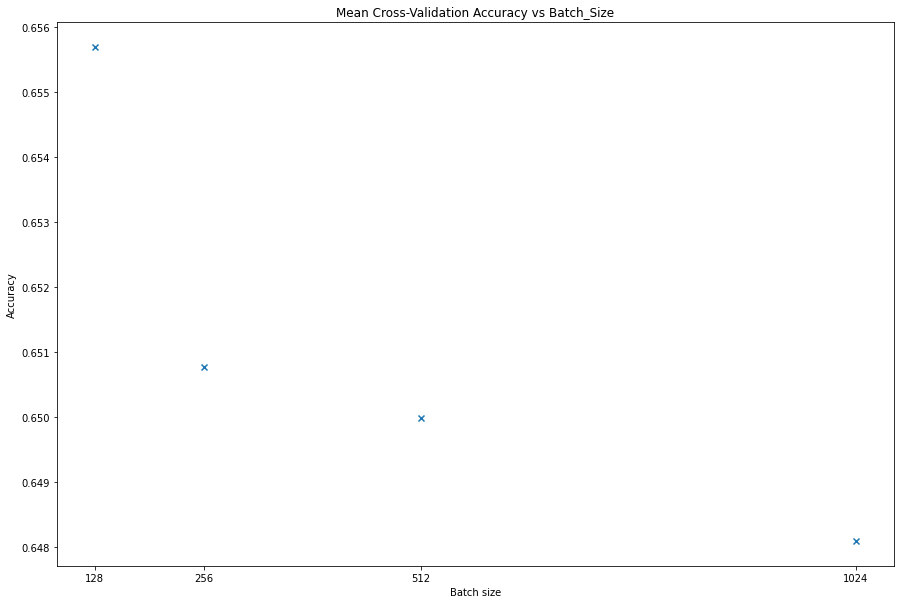

In [19]:
mean_val_acc = []
for key, value in model_acc.items():
    mean_val_acc.append(np.mean(value))

mean_val_loss = []
for key, value in model_loss.items():
    mean_val_loss.append(np.mean(value))

plt_1 = plt.figure(figsize=(15, 10))
plt.scatter(batch_size_list, mean_val_acc, marker = 'x')
plt.title('Mean Cross-Validation Accuracy vs Batch_Size')
plt.ylabel('Accuracy')
plt.xlabel('Batch size')
plt.xticks(batch_size_list)
plt.show()



## Question 2B) 


In [20]:
mean_time_taken = []
for key, value in time_taken_dict.items():
    mean_time_taken.append(np.mean(value))

#### Table of time taken to train the last epoch

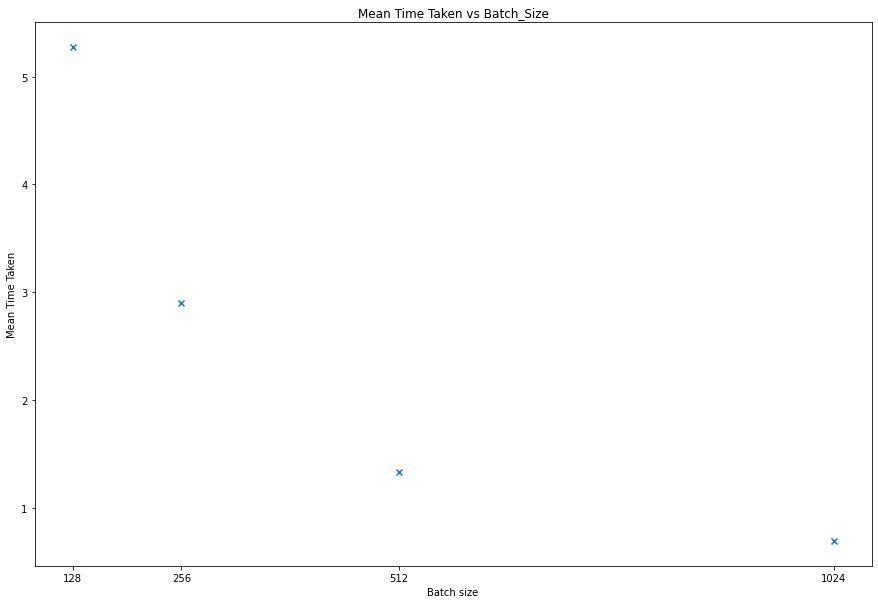

In [21]:
plt_1 = plt.figure(figsize=(15, 10))
plt.scatter(batch_size_list, mean_time_taken, marker = 'x')
     
plt.title('Mean Time Taken vs Batch_Size')
plt.ylabel('Mean Time Taken')
plt.xlabel('Batch size')
plt.xticks(batch_size_list)
plt.show()

In [22]:
table_df = pd.DataFrame.from_dict(model_acc,orient='index', columns=["fold_0", "fold_1", "fold_2", "fold_3", "fold_4"])
table_df["mean_val_acc"] = mean_val_acc
table_df["mean_val_loss"] = mean_val_loss
table_df["mean_time_taken"] = mean_time_taken
table_df["Batch model"] = model_list
table_df["Batch_size"] = batch_size_list
table_df.set_index('Batch_size', inplace = True)
table_df.head()

,fold_0,fold_1,fold_2,fold_3,fold_4,mean_val_acc,mean_val_loss,mean_time_taken,Batch model
Batch_size,,,,,,,,,
128,0.652924,0.657117,0.652988,0.653968,0.661493,0.655698,0.610460,5.274666,model_128
256,0.652649,0.657979,0.644288,0.642015,0.656947,0.650776,0.615205,2.903057,model_256
512,0.648730,0.656568,0.651382,0.647580,0.645620,0.649976,0.614913,1.333229,model_512
1024,0.659782,0.643283,0.656673,0.643504,0.637194,0.648087,0.618041,0.695874,model_1024


In [23]:
optimal_batch_size = int(table_df['mean_val_acc'].idxmax())
print("Optimal batch size: ", optimal_batch_size)

Optimal batch size:  128


## Question 2C) 
#### Select the optimal batch size and state a reason for your selection

**The optimal batch size is selected based on the highest mean accuracy that is evaluted through the K-fold cross validation. K-fold cross validation generally results in a less-biased estimate of the model performance as compared to a simple train-test split method.**



## Question 2D) 

#### What happens when batch size increases, and why does it happen?

**As the batch size increases, the training time taken for the final epoch decreases. Holding the number of epochs constant, the total number of gradient descent steps decreases when batch size increases. However one thing to note, when batch size reach to large enough size, it is possible for the difference in time taken to be less significant.**


## Question 2E) 


#### Line Plot of Accuracy vs Epochs for optimal batch size

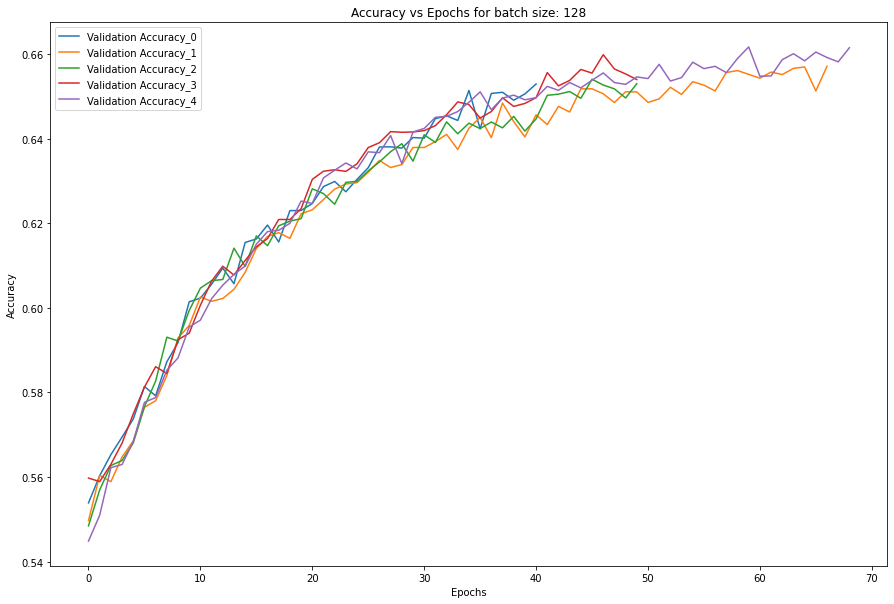

In [24]:
plt_1 = plt.figure(figsize=(15, 10))
optimal_batch_model = str(table_df.loc[optimal_batch_size, "Batch model"])
fold = 0

Q2_legend_list = []

while(fold<no_folds):
    plt.plot(Q2_history[optimal_batch_model + model_fold[fold]].history["val_accuracy"])
    Q2_legend_list.append("Validation Accuracy" + model_fold[fold])
    fold+=1

plt.legend(Q2_legend_list)
plt.title('Accuracy vs Epochs for batch size: ' + str(optimal_batch_size))
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.show()

## QUESTION 3

In [25]:
model_neurons_list = ["model_neurons_64", "model_neurons_128", "model_neurons_256"]
num_neurons_list = [64,128,256]

Q3_X, Q3_Y = X_train_scaled, y_train
neurons_idx = 0

In [26]:
Q3_cb = TimingCallback()
Q3_time_taken_dict = {}
Q3_model_acc = {}
Q3_model_train_acc = {}
Q3_model_loss = {}
Q3_history = {}
for model_neurons in model_neurons_list:    
    fold = 0
    val_acc = []
    train_acc = []
    val_loss = []
    time_taken_list = []
    for train_idx, test_idx in cv.split(Q3_X, Q3_Y):
        Q3_cb = TimingCallback()
        Q3_X_train, Q3_y_train  = Q3_X[train_idx], Q3_Y[train_idx]
        Q3_X_test, Q3_y_test = Q3_X[test_idx], Q3_Y[test_idx]
        Q3_model = Sequential([Dense(num_neurons_list[neurons_idx], activation='relu'),
                        Dropout(0.2), Dense(num_neurons_list[neurons_idx], activation ='relu'),
                        Dropout(0.2), Dense(num_neurons_list[neurons_idx], activation='relu'),
                        Dropout(0.2), Dense(1, activation='sigmoid')])
        
        Q3_model.compile(optimizer='adam', 
                    loss='binary_crossentropy',
                    metrics=['accuracy'])
        
        Q3_history[model_neurons + model_fold[fold]] = Q3_model.fit(Q3_X_train, Q3_y_train,
                        batch_size = optimal_batch_size,
                        epochs=no_epochs,
                        verbose=0,
                        use_multiprocessing=True,
                        validation_data=(Q3_X_test, Q3_y_test), callbacks=[callback, Q3_cb])
        
        #Time taken of final epoch for each fold 
        time_taken_list.append(Q3_cb.times[-1])
        #print("Time Taken for final epoch " + model_neurons + model_fold[fold] + ": {}".format(Q3_cb.times[-1]))

        #Val accuracy of final epoch of each fold
        val_acc.append(Q3_history[model_neurons + model_fold[fold]].history['val_accuracy'][-1])

        #Train accuracy of final epoch of each fold
        train_acc.append(Q3_history[model_neurons + model_fold[fold]].history['accuracy'][-1])

        #Val loss of final epoch of each fold
        val_loss.append(Q3_history[model_neurons + model_fold[fold]].history['val_loss'][-1])
        
        #print(model_neurons +' fold %d test accuracy %g'%(fold, val_acc[fold]))
        fold += 1
    
    Q3_model_acc[model_neurons] = val_acc
    Q3_model_train_acc[model_neurons] = train_acc
    Q3_time_taken_dict[model_neurons]= time_taken_list
    Q3_model_loss[model_neurons] = val_loss
    print(model_neurons + '* mean accuracy = %g *'% np.mean(val_acc))
    neurons_idx+=1

model_neurons_64* mean accuracy = 0.604944 *
model_neurons_128* mean accuracy = 0.646919 *
model_neurons_256* mean accuracy = 0.693824 *


## Question 3A


#### Mean cross-validation accuracies on the final epoch for different numbers of hidden-layer neurons

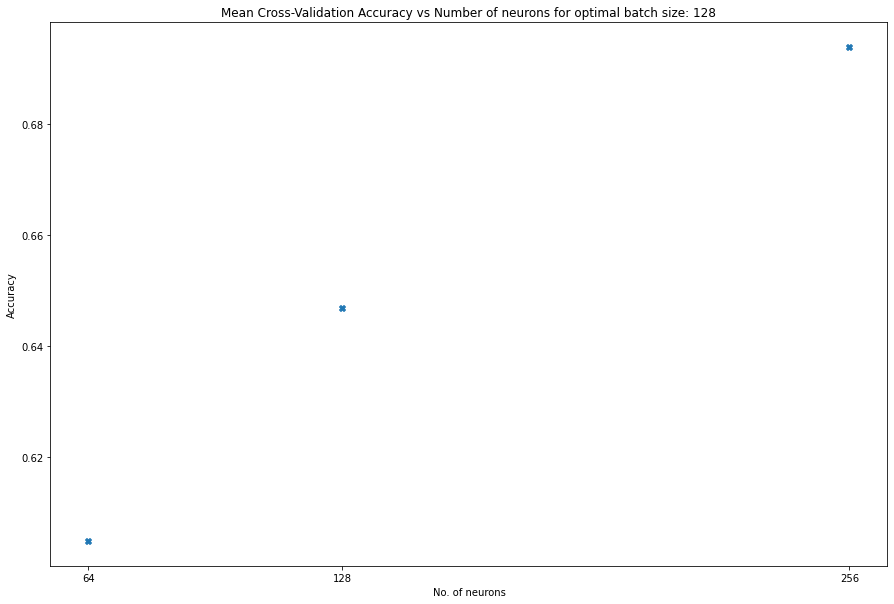

In [27]:
Q3_mean_val_acc = []
for key, value in Q3_model_acc.items():
    Q3_mean_val_acc.append(np.mean(value))

Q3_mean_val_loss = []
for key, value in Q3_model_loss.items():
    Q3_mean_val_loss.append(np.mean(value))

plt_1 = plt.figure(figsize=(15, 10))
plt.scatter(num_neurons_list, Q3_mean_val_acc, marker = 'X')
plt.title('Mean Cross-Validation Accuracy vs Number of neurons for optimal batch size: {}'.format(optimal_batch_size))
plt.ylabel('Accuracy')
plt.xlabel('No. of neurons')
plt.xticks(num_neurons_list)
plt.show()

In [28]:
Q3_mean_time_taken = []
for key, value in Q3_time_taken_dict.items():
    Q3_mean_time_taken.append(np.mean(value))

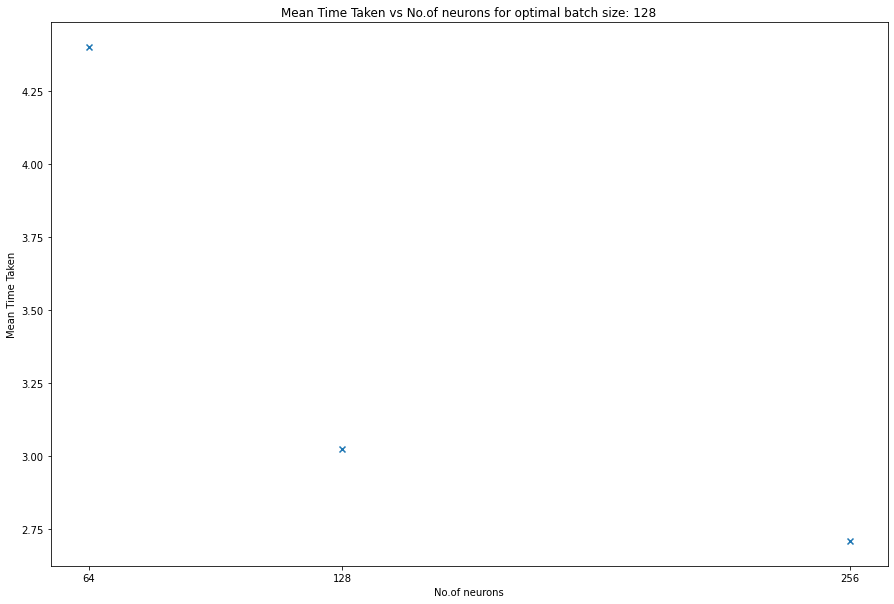

In [29]:
plt_1 = plt.figure(figsize=(15, 10))
plt.scatter(num_neurons_list, Q3_mean_time_taken, marker = 'x')
     
plt.title('Mean Time Taken vs No.of neurons for optimal batch size: {}'.format(optimal_batch_size))
plt.ylabel('Mean Time Taken')
plt.xlabel('No.of neurons')
plt.xticks(num_neurons_list)
plt.show()

## Question 3B 
#### Select the optimal number of neurons for the hidden layer

In [30]:
Q3_table_df = pd.DataFrame.from_dict(Q3_model_acc,orient='index', columns=["fold_0", "fold_1", "fold_2", "fold_3", "fold_4"])
Q3_table_df["mean_val_acc"] = Q3_mean_val_acc
Q3_table_df["mean_val_loss"] = Q3_mean_val_loss
Q3_table_df["mean_time_taken"] = Q3_mean_time_taken
Q3_table_df["No. of neurons"] = num_neurons_list
Q3_table_df["Model Neuron List"] = model_neurons_list
Q3_table_df.set_index('No. of neurons', inplace = True)
Q3_table_df.head()

,fold_0,fold_1,fold_2,fold_3,fold_4,mean_val_acc,mean_val_loss,mean_time_taken,Model Neuron List
No. of neurons,,,,,,,,,
64,0.601074,0.607070,0.609328,0.601999,0.605252,0.604944,0.653262,4.400432,model_neurons_64
128,0.642264,0.650063,0.645424,0.654321,0.642524,0.646919,0.618362,3.023051,model_neurons_128
256,0.701011,0.689842,0.695121,0.682853,0.700294,0.693824,0.569263,2.708461,model_neurons_256


In [31]:
optimal_no_neurons = int(Q3_table_df['mean_val_acc'].idxmax())

data = {"Optimal Batch": [optimal_batch_size], "Optimal No.of neurons": [optimal_no_neurons] }

data_df = pd.DataFrame.from_dict(data)
data_df

Optimal number of neurons: 256
Optimal batch size: 128


,Optimal Batch,Optimal No.of neurons
0,128,256


**Optimal number of neurons produces the best accuracy**

## Question 3C 


#### Train & Test accuracy against training epochs with the optimal number of neurons

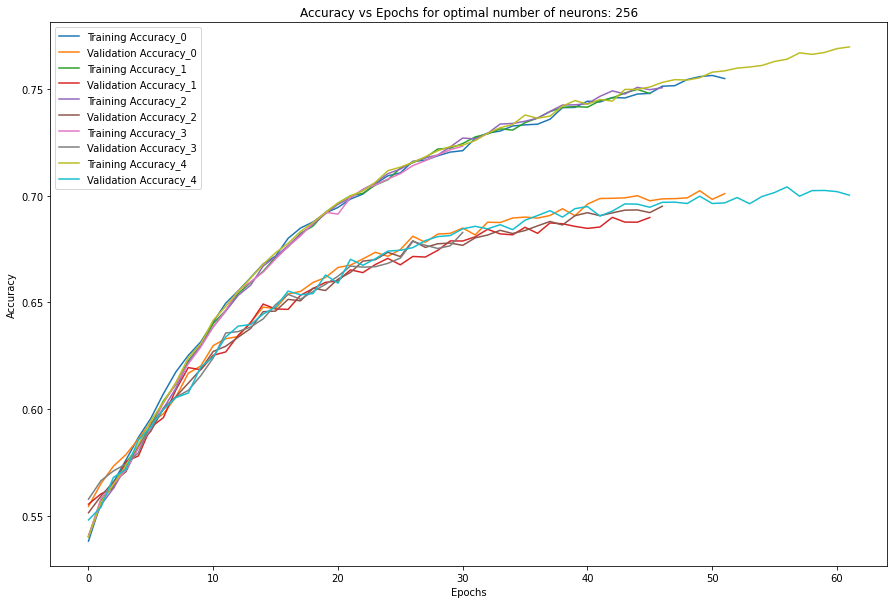

In [32]:
plt_1 = plt.figure(figsize=(15, 10))
fold = 0
optimal_neuron_model = str(Q3_table_df.loc[optimal_no_neurons, "Model Neuron List"])

Q3_legend_list = []

while(fold<no_folds):

    plt.plot(Q3_history[optimal_neuron_model + model_fold[fold]].history["accuracy"])
    Q3_legend_list.append("Training Accuracy" + model_fold[fold])

    plt.plot(Q3_history[optimal_neuron_model + model_fold[fold]].history["val_accuracy"])
    Q3_legend_list.append("Validation Accuracy" + model_fold[fold])
    fold+=1

plt.legend(Q3_legend_list)
plt.title('Accuracy vs Epochs for optimal number of neurons: ' + str(optimal_no_neurons))
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.show()

## Question 3D 
#### How does dropout works, and what is the purpose of dropouts?

**Dropout is a technique where randomly selected neurons are ignored during training to avoid overfitting. Dropout prevents all neurons in a layer from syncrhonously optimizing their weights. It precents all the neurons from converging to the same goal, thus decorrelating the weights. As such, it increases the robustness of the model and reomves the simple dependencies between the neurons.**



## Question 3E 
#### Besides early stopping and dropout, what is another approach that you could take to address overfitting in the model, and how does it work? Implement the approach

**Weight regularization. Weight regularization ensures that the weights of the network as large network weights indicates that the model is overfitting. The learning algorithm would encourage the network towards using small weights by penalizing the model with a larger loss score.**

## QUESTION 4

In [33]:
# Implementation of weight regularization with optimal batch and number of neurons
from tensorflow.keras import regularizers

optimized_model = Sequential([Dense(optimal_no_neurons, activation='relu', kernel_regularizer =regularizers.L2(0.000001)),
                        Dropout(0.2), Dense(optimal_no_neurons, activation ='relu', kernel_regularizer =regularizers.L2(0.000001)),
                        Dropout(0.2), Dense(optimal_no_neurons, activation='relu', kernel_regularizer =regularizers.L2(0.000001)),
                        Dropout(0.2), Dense(1, activation='sigmoid')])

#default values for l1 and l2 are 0.01

optimized_model.compile(optimizer='adam', 
                    loss='binary_crossentropy',
                    metrics=['accuracy'])

In [34]:
Q4_history = {}
Q4_history['optimized_model'] = optimized_model.fit(X_train_scaled, y_train,
                            epochs = no_epochs, verbose = 1,
                            batch_size = optimal_batch_size, validation_data = (X_test_scaled, y_test), callbacks = [callback])

Epoch 1/100
997/997 [==============================] - 5s 5ms/step - loss: 0.6883 - accuracy: 0.5424 - val_loss: 0.6834 - val_accuracy: 0.5537
Epoch 2/100
997/997 [==============================] - 5s 5ms/step - loss: 0.6819 - accuracy: 0.5577 - val_loss: 0.6812 - val_accuracy: 0.5581
Epoch 3/100
997/997 [==============================] - 5s 5ms/step - loss: 0.6779 - accuracy: 0.5650 - val_loss: 0.6775 - val_accuracy: 0.5701
Epoch 4/100
997/997 [==============================] - 4s 4ms/step - loss: 0.6724 - accuracy: 0.5752 - val_loss: 0.6707 - val_accuracy: 0.5788
Epoch 5/100
997/997 [==============================] - 4s 4ms/step - loss: 0.6657 - accuracy: 0.5865 - val_loss: 0.6659 - val_accuracy: 0.5911
Epoch 6/100
997/997 [==============================] - 4s 4ms/step - loss: 0.6569 - accuracy: 0.6009 - val_loss: 0.6584 - val_accuracy: 0.5969
Epoch 7/100
997/997 [==============================] - 4s 4ms/step - loss: 0.6480 - accuracy: 0.6125 - val_loss: 0.6502 - val_accuracy: 0.6133

In [35]:
optimized_model.save('optimized_model/')

INFO:tensorflow:Assets written to: optimized_model/assets


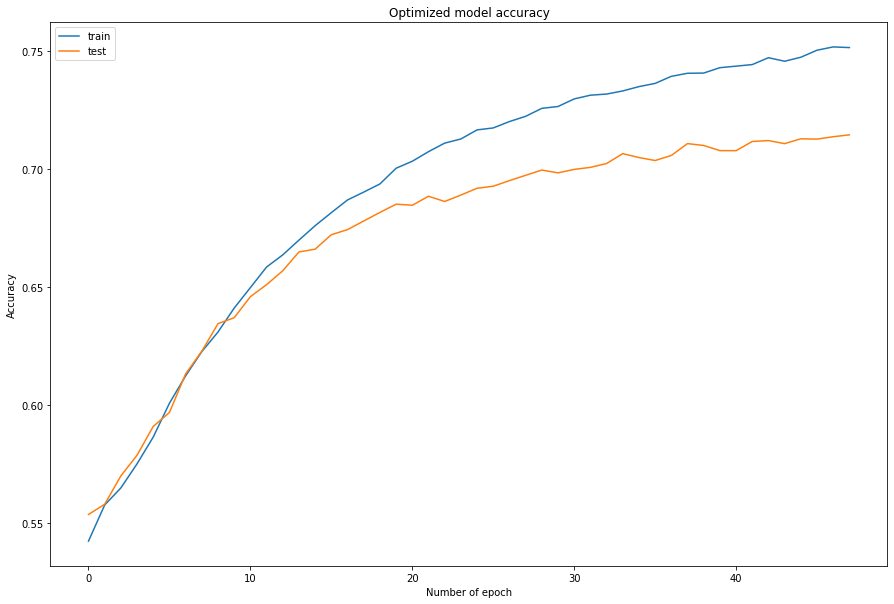

In [36]:
plt_1 = plt.figure(figsize=(15, 10))
plt.plot(Q4_history['optimized_model'].history['accuracy'])
plt.plot(Q4_history['optimized_model'].history['val_accuracy'])
plt.title('Optimized model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Number of epoch')
plt.legend(['train', 'test'], loc='upper left')
#plt.savefig('figures/1a_accuracy.png')
plt.show()

## Question 4A

In [37]:

neg_voice_record_df = pd.read_csv('Q4_neg_voice_record.csv')
pos_voice_record_df = pd.read_csv('Q4_pos_voice_record.csv')
threshold = 0.5


In [38]:
neg_voice_record_df = neg_voice_record_df.drop(["filename"],axis = 1)
pos_voice_record_df = pos_voice_record_df.drop(["filename"], axis=1)



In [39]:
def process_dataset(df_train, df_test):
    
  standard_scaler = preprocessing.StandardScaler()
  df_train_scaled = standard_scaler.fit_transform(df_train)

  df_test_scaled = standard_scaler.transform(df_test)

  return df_test_scaled


neg_voice_record_df_scaled = process_dataset(X_train, neg_voice_record_df)
pos_voice_record_df_scaled = process_dataset(X_train, pos_voice_record_df)

## Question 4B 
**Do a model prediction on your sample test dataset with threshold = 0.5**

In [40]:


neg_result_label = (optimized_model.predict(neg_voice_record_df_scaled)>threshold).astype("int32")
pos_result_label = (optimized_model.predict(pos_voice_record_df_scaled)>threshold).astype("int32")

data = {"Label": ["Negative Voice ", "Positive Voice"],"Result":[neg_result_label, pos_result_label]}


data_df = pd.DataFrame.from_dict(data)
data_df

1/1 [==============================] - 0s 18ms/step


,Label,Result
0,Negative Voice,[[1]]
1,Positive Voice,[[0]]


## Question 4C) 
**Identify most important features using SHAP**

In [41]:

tf.compat.v1.disable_v2_behavior()
tf.compat.v1.disable_eager_execution()

Instructions for updating:
non-resource variables are not supported in the long term


In [42]:
X_train_sample = X_train_scaled[np.random.choice(len(X_train_scaled), 100, replace=False)]
X_test_sample = X_test_scaled[np.random.choice(len(X_test_scaled), 100, replace=False)]

In [43]:
model = keras.models.load_model('optimized_model/')
explainer = shap.DeepExplainer(model , X_train_sample)

keras is no longer supported, please use tf.keras instead.
Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.


In [44]:
shap_values = explainer.shap_values(neg_voice_record_df_scaled)
shap.force_plot(explainer.expected_value[0], shap_values[0][0], features = X_test.columns)

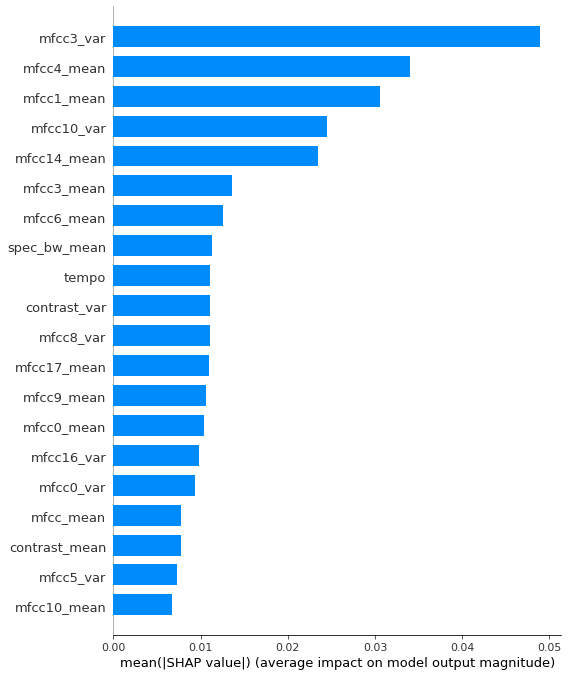

In [45]:
shap.summary_plot(shap_values[0], plot_type = 'bar', feature_names = X_test.columns)

In [1]:
shap_values = explainer.shap_values(pos_voice_record_df_scaled)
shap.force_plot(explainer.expected_value[0], shap_values[0][0], features = X_test.columns)

NameError: name 'explainer' is not defined

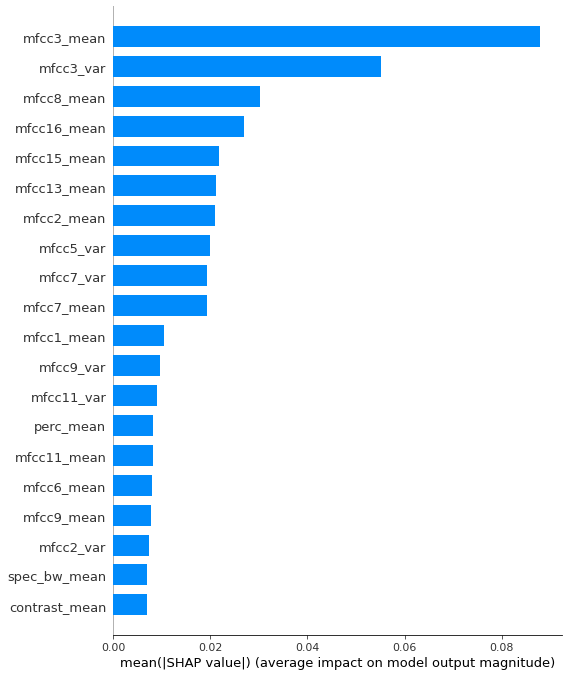

In [47]:
shap.summary_plot(shap_values[0], plot_type = 'bar', feature_names = X_test.columns)

**Most Important Features**

## Discussion Point